# Prompt Analysis

The goal of this notebook is to analyse the different recall for the prompt proposed by this paper and the prompt used by the Power of Noise work.  

To do so we will analyse the distribution of the collections evaluations and also the number of non-zero collections

In [1]:
import os
import random
import numpy as np
import torch

import json
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
seed = 42

torch.backends.cudnn.enabled = False
# NumPy
np.random.seed(seed)
random.seed(seed)
# PyTorch
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False



if torch.cuda.is_available():
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Number of GPUs available: 1
GPU 0: Tesla T4


## Loading Data

In [3]:
## Load data for new prompt
COLLECTIONS_NEW_PROMPT = "new_prompt/datamodels/collections"
np_train_collection_rouge = pl.read_ipc(f"{COLLECTIONS_NEW_PROMPT}/train/new_prompt_preview_50_cosine_train_collection_0.feather")
np_train_collection_f1score = pl.read_ipc(f"{COLLECTIONS_NEW_PROMPT}/train/new_prompt_f1score_0.feather")
np_test_collection_rouge = pl.read_ipc(f"{COLLECTIONS_NEW_PROMPT}/test/new_prompt_preview_50_cosine_test_collection_0.feather")
np_test_collection_f1score = pl.read_ipc(f"{COLLECTIONS_NEW_PROMPT}/test/new_prompt_f1score_0.feather")

## Number of Nonzeros

In [19]:
nonzeros_train_rouge = np_train_collection_rouge.filter(pl.col("evaluation") > 0).count().select("evaluation").to_numpy()[0][0]
nonzeros_train_f1score = np_train_collection_f1score.filter(pl.col("evaluation") > 0).count().select("evaluation").to_numpy()[0][0]
nonzeros_test_rouge = np_test_collection_rouge.filter(pl.col("evaluation") > 0).count().select("evaluation").to_numpy()[0][0]
nonzeros_test_f1score = np_test_collection_f1score.filter(pl.col("evaluation") > 0).count().select("evaluation").to_numpy()[0][0]

print(nonzeros_train_rouge, nonzeros_train_f1score, nonzeros_test_rouge, nonzeros_test_f1score)

21141 16008 4159 3164


## Plot Result Distributions

/tmp/ipykernel_2773318/2910155088.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center')


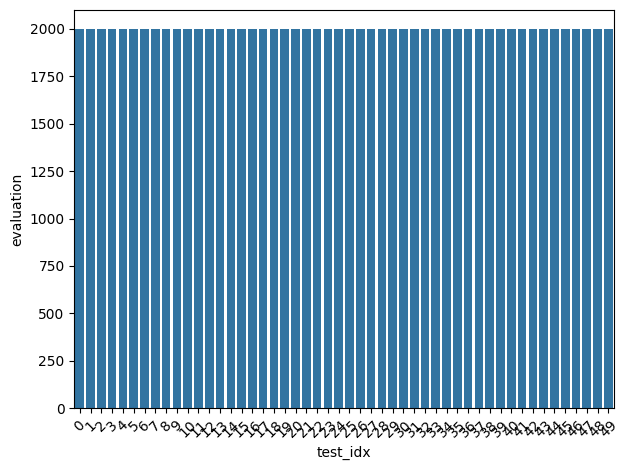

In [ ]:
_df = (
    np_train_collection_rouge
    .group_by("test_idx")
    .with_column(pl.when(pl.col("evaluation") > 0).then(1).otherwise(0).alias("nonzero_evaluation"))
    .agg(pl.col("evaluation").count())
    .sort("test_idx")
)
ax = sns.barplot(
    data = _df,
    x = "test_idx",
    y = "evaluation"
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='center')

# Improve spacing (optional)
plt.tight_layout()
plt.show()

<Axes: xlabel='test_idx', ylabel='evaluation'>

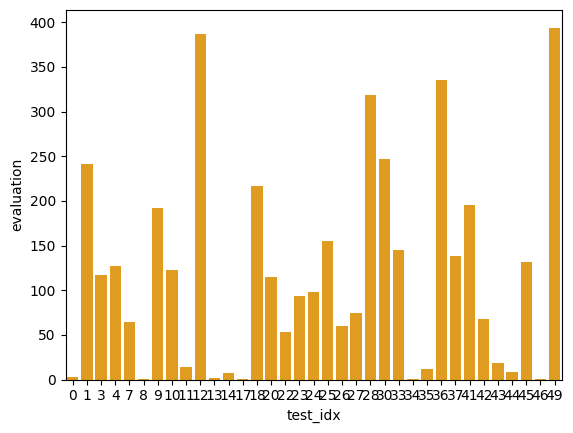

In [25]:
_df = np_test_collection_rouge.filter(pl.col("evaluation") > 0).group_by("test_idx").agg(pl.col("evaluation").count()).sort("test_idx")
sns.barplot(
    data = _df,
    x = "test_idx",
    y = "evaluation",
    color="orange"
)

<Axes: xlabel='evaluation', ylabel='Count'>

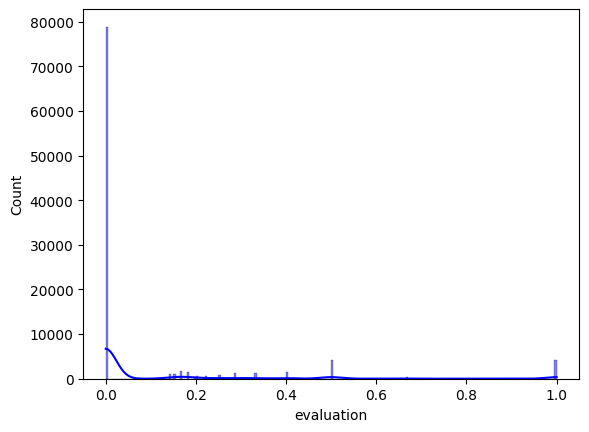

In [9]:
## Train - Rouge-l
sns.histplot(
    data = np_train_collection_rouge.select("evaluation"),
    x = "evaluation",
    bins = 200,
    kde = True,
    color="blue"
)

<Axes: xlabel='evaluation', ylabel='Count'>

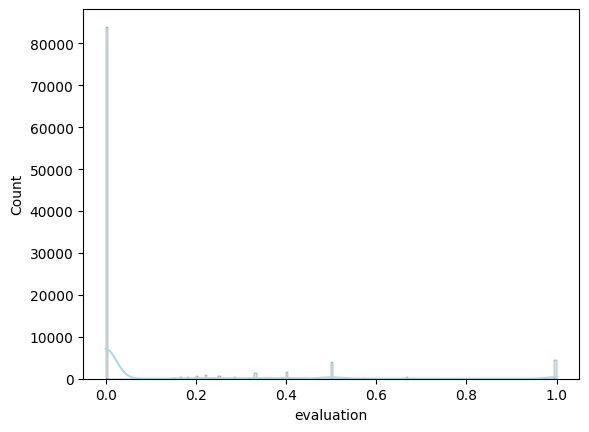

In [11]:
## Train - F1Score
sns.histplot(
    data = np_train_collection_f1score.select("evaluation"),
    x = "evaluation",
    bins = 200,
    kde = True,
    color="lightblue"
)